In [ ]:
!pip install fbprophet
!pip install sktime
!pip install pmdarima

     |████████████████████████████████| 5.7MB 10.3MB/s 
     |████████████████████████████████| 22.3MB 1.2MB/s 
     |████████████████████████████████| 9.5MB 53.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 1.5MB 11.8MB/s 
     |████████████████████████████████| 2.1MB 41.5MB/s 
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from IPython.display import display

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
# アメリカンフットボールプレーヤのPayton ManningのWikiアクセス数
df = pd.read_csv('http://logopt.com/data/peyton_manning.csv')
display(df.head())
display(df.tail())
print(df.dtypes)
print(df.shape)

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


,ds,y
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


ds     object
y     float64
dtype: object
(2905, 2)


In [ ]:
df['ds'] = pd.to_datetime(df['ds'])
print(df.dtypes)

ds    datetime64[ns]
y            float64
dtype: object


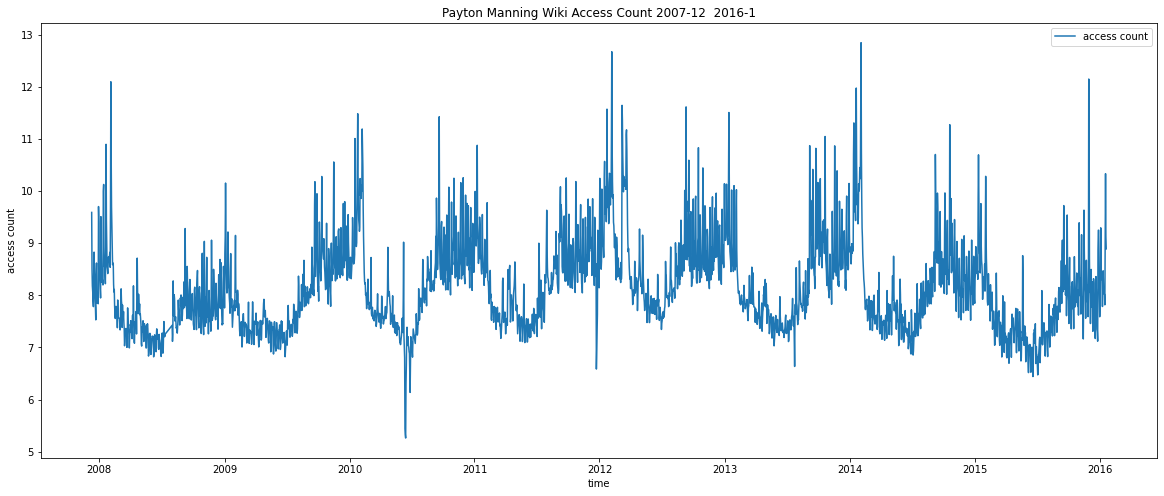

In [ ]:
# グラフ表示
fig = plt.figure(figsize=(20, 8))

plt.title("Payton Manning Wiki Access Count 2007-12  2016-1")
plt.xlabel("time")
plt.ylabel("access count")

plt.plot(df["ds"], df["y"], label="access count")
plt.legend()
plt.show()

### データの分割

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
train, test = temporal_train_test_split(df, test_size=365)

In [ ]:
print(train.shape, test.shape)

(2540, 2) (365, 2)


### Prophet

In [ ]:
from fbprophet import Prophet

In [ ]:
# モデルの作成
model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=True)

# 学習
model.fit(train)

# 予測データの作成
pred = model.predict(test)
pred.head()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-19,9.347069,8.889400,10.118743,9.347069,9.347069,0.147068,0.147068,0.147068,-1.264385,-1.264385,-1.264385,0.351867,0.351867,0.351867,1.059586,1.059586,1.059586,0.0,0.0,0.0,9.494137
1,2015-01-20,9.346658,8.672168,9.899814,9.346658,9.346658,-0.069203,-0.069203,-0.069203,-1.264385,-1.264385,-1.264385,0.111826,0.111826,0.111826,1.083355,1.083355,1.083355,0.0,0.0,0.0,9.277455
2,2015-01-21,9.346248,8.486413,9.769315,9.346248,9.346248,-0.235428,-0.235428,-0.235428,-1.264385,-1.264385,-1.264385,-0.076374,-0.076374,-0.076374,1.105331,1.105331,1.105331,0.0,0.0,0.0,9.110819
3,2015-01-22,9.345837,8.511887,9.688719,9.345837,9.345837,-0.224442,-0.224442,-0.224442,-1.264385,-1.264385,-1.264385,-0.085123,-0.085123,-0.085123,1.125065,1.125065,1.125065,0.0,0.0,0.0,9.121395
4,2015-01-23,9.345427,8.530576,9.751562,9.345427,9.345427,-0.200839,-0.200839,-0.200839,-1.264385,-1.264385,-1.264385,-0.078534,-0.078534,-0.078534,1.142080,1.142080,1.142080,0.0,0.0,0.0,9.144588


In [ ]:
pred_prophet = pred["yhat"]

### Sktime

In [ ]:
from sktime.forecasting.all import *

In [ ]:
# 日時データをindexに変換
train_sk = train.set_index("ds")
test_sk = test.set_index("ds")

# 学習
model = ThetaForecaster(sp=365)
model.fit(train["y"])

fh = ForecastingHorizon(test.index, is_relative=False)

# 予測データの作成
pred_sktime = model.predict(fh)

### LSTM

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.optimizers import Adam
import tensorflow as tf

In [ ]:
# 目的変数と説明変数の作成
def make_dataset(low_data, maxlen):

    data, target = [], []

    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen])
        target.append(low_data[i + maxlen])

    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target

# RNNへの入力データ数
window_size = 12

# 入力データと教師データへの分割
X, y = make_dataset(df["y"], window_size)

In [ ]:
# データの分割
X_train, X_test, y_train, y_test = temporal_train_test_split(X, y, test_size=365)

In [ ]:
# validation データの作成
X_train, X_val, y_train, y_val = temporal_train_test_split(X_train, y_train, test_size=365)

In [ ]:
# ネットワークの構築
model = Sequential() # Sequentialモデル

model.add(LSTM(50, batch_input_shape=(None, window_size, 1))) # LSTM 50層
model.add(Dense(1)) # 出力次元数は1

#コンパイル
model.compile(loss='mean_squared_error', optimizer=Adam() , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


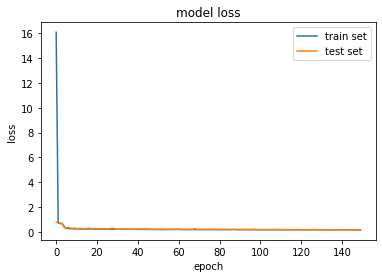

In [ ]:
# 学習用パラメータ
batch_size = 20
n_epoch = 150

# 学習
hist = model.fit(X_train, y_train,
                 epochs=n_epoch,
                 validation_data=(X_val, y_val),
                 verbose=0,
                 batch_size=batch_size)

# 損失値(Loss)の遷移のプロット
plt.plot(hist.history['loss'],label="train set")
plt.plot(hist.history['val_loss'],label="test set")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 予測
pred_lstm = model.predict(X_test)

### lightGBM



In [ ]:
import lightgbm as lgbm

In [ ]:
# 元のデータを残すため、別途コピー
df_lag = df.copy()

In [ ]:
# 時系列特徴量の作成
df_lag["year"]  = df_lag["ds"].dt.year
df_lag["month"] = df_lag["ds"].dt.month
df_lag["day"]  = df_lag["ds"].dt.day
df_lag["dayofweek"] = df_lag["ds"].dt.dayofweek

In [ ]:
# ラグの作成 簡単に1週間と1ヶ月で作成
for i in [7, 30]:
    df_lag[f"shift{i}"] = df_lag["y"].shift(i)

# 差分の作成
for i in [7, 30]:
    df_lag[f"deriv{i}"] = df_lag[f"shift{i}"].diff(i)

# 移動平均の作成
for i in [7, 30]:
    df_lag[f"mean{i}"] = df_lag[f"shift{i}"].rolling(12).mean()

# 中央値、最大値、最小値の作成
for i in [7, 30]:
    df_lag[f"median{i}"] = df_lag[f"shift{i}"].rolling(12).median()

for i in [7, 30]:
    df_lag[f"max{i}"] = df_lag[f"shift{i}"].rolling(12).max()

for i in [7, 30]:
    df_lag[f"min{i}"] = df_lag[f"shift{i}"].rolling(12).min()

In [ ]:
# NaN部分を削除
df_lag = df_lag[41:]

In [ ]:
# ds列をindexにして説明変数から除外
df_lag = df_lag.set_index("ds")

In [ ]:
train_lag, test_lag = temporal_train_test_split(df_lag, test_size=365)

In [ ]:
# 学習
model = lgbm.LGBMRegressor()
model.fit(train_lag.drop("y", axis=1), train_lag["y"])

# 予測データの作成
pred_lgbm = model.predict(test_lag.drop("y", axis=1))

### 比較

In [ ]:
compare_pred = test.reset_index()[["ds", "y"]]
compare_pred = compare_pred.rename(columns={"y":"test_data"})
compare_pred.head()

,ds,test_data
0,2015-01-19,9.759386
1,2015-01-20,8.952088
2,2015-01-21,8.661120
3,2015-01-22,8.584852
4,2015-01-23,8.396606


In [ ]:
compare_pred["Prophet"] = pred_prophet.reset_index()["yhat"]
compare_pred["sktime"] = pred_sktime.reset_index()[0]
compare_pred["LSTM"] = pred_lstm
compare_pred["lightGBM"] = pred_lgbm

print(compare_pred.shape)
display(compare_pred.head())

(365, 6)


,ds,test_data,Prophet,sktime,LSTM,lightGBM
0,2015-01-19,9.759386,9.494137,8.498087,9.399217,9.894804
1,2015-01-20,8.952088,9.277455,8.620184,9.465807,9.752545
2,2015-01-21,8.661120,9.110819,8.697031,8.824220,9.164780
3,2015-01-22,8.584852,9.121395,8.526009,8.691818,9.089472
4,2015-01-23,8.396606,9.144588,8.531167,8.595029,8.834026


R2スコア 0.546316880353727
RMSE 0.48717940947755595


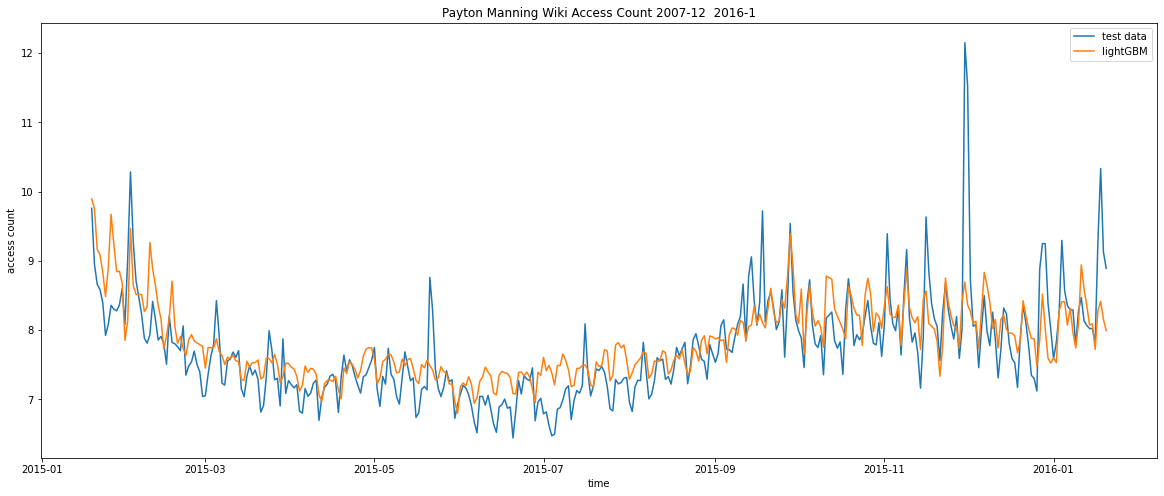

In [ ]:
# Google Colab用
#@title 予測モデルを選択
dropdown = 'lightGBM' #@param ["Prophet", "sktime", "LSTM", "lightGBM"]
print("R2スコア", r2_score(compare_pred["test_data"], compare_pred[dropdown]))
print("RMSE", np.sqrt(mean_squared_error(compare_pred["test_data"], compare_pred[dropdown])))

# 選択した予測結果と実績をグラフ表示
fig = plt.figure(figsize=(20, 8))

plt.title("Payton Manning Wiki Access Count 2007-12  2016-1")
plt.xlabel("time")
plt.ylabel("access count")

plt.plot(test["ds"], test["y"], label="test data")
plt.plot(test["ds"], compare_pred[dropdown], label=dropdown)

plt.legend()
plt.show()

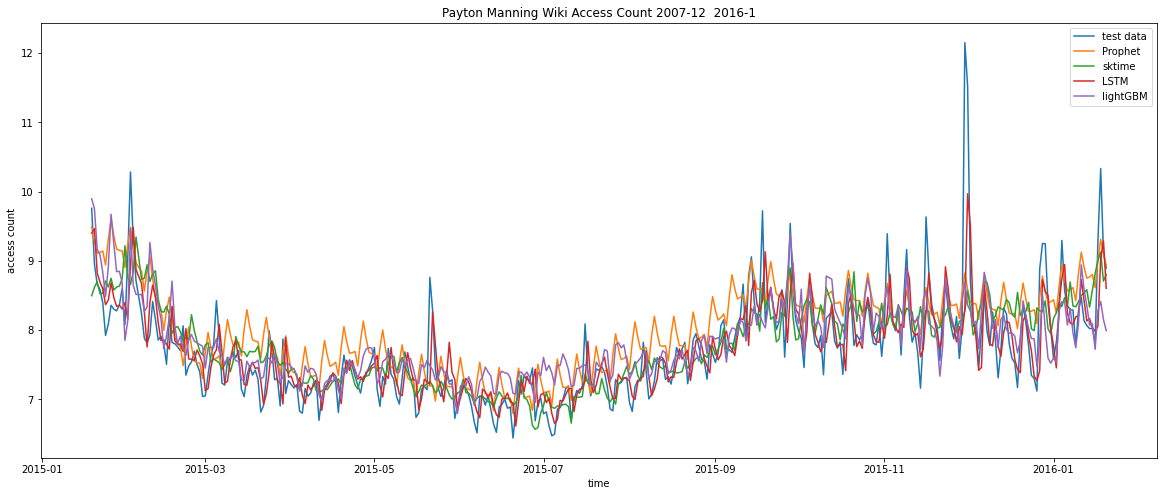

In [ ]:
# 全グラフ表示
fig = plt.figure(figsize=(20, 8))

plt.title("Payton Manning Wiki Access Count 2007-12  2016-1")
plt.xlabel("time")
plt.ylabel("access count")

plt.plot(test["ds"], test["y"], label="test data")
plt.plot(test["ds"], pred_prophet, label="Prophet") # Prophet
plt.plot(test["ds"], pred_sktime, label="sktime") # sktime
plt.plot(test["ds"], pred_lstm, label="LSTM") # LSTM
plt.plot(test["ds"], pred_lgbm, label="lightGBM") # lightGBM

plt.legend()
plt.show()

In [ ]:
for i in ['Prophet', 'sktime', 'LSTM', 'lightGBM']:
    print(i)
    print("R2スコア",r2_score(compare_pred["test_data"], compare_pred[i]))
    print("RMSE", np.sqrt(mean_squared_error(compare_pred["test_data"], compare_pred[i])),"\n")

Prophet
R2スコア 0.42594969350334355
RMSE 0.548008873731168 

sktime
R2スコア 0.5176028406784783
RMSE 0.5023599230166854 

LSTM
R2スコア 0.6668046432993786
RMSE 0.4175053881219272 

lightGBM
R2スコア 0.546316880353727
RMSE 0.48717940947755595 

